## Load the Adult Data

In [1]:
## If Running in google colab
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir_path = '/content/drive/MyDrive/CSE_248/'


In [1]:
!pip install torch folktables

  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
  Using cached sklearn-0.0-py2.py3-none-any.whl
  Using cached idna-3.3-py3-none-any.whl (61 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Using cached urllib3-1.26.9-py2.py3-none-any.whl (138 kB)
  Created wheel for folktables: filename=folktables-0.0.11-py3-none-any.whl size=6772 sha256=5adacc1e77fb25f581b9bea5bc06c58a7eddb5557d20d60a6a52fded6a90a991
  Stored in directory: /Users/ianhardy/Library/Caches/pip/wheels/bd/63/b8/24d3f5d2c70002c68c1fe8e78e1de20fcbcb7a2ef3f56147b7
Successfully built folktables


In [2]:
!pip install torchattacks

     |████████████████████████████████| 105 kB 5.6 MB/s eta 0:00:01


In [1]:
import numpy as np
import torch
import torchattacks
from torch.utils.data import TensorDataset, DataLoader
from folktables import ACSDataSource, ACSEmployment, ACSIncome

Load the Adult dataset as numpy array.

In [2]:
data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(ca_data)

In [3]:
features

array([[36.,  1., 16., ..., 35.,  1.,  1.],
       [47.,  1., 20., ..., 60.,  2.,  1.],
       [20.,  1., 19., ..., 40.,  1.,  1.],
       ...,
       [40.,  1., 21., ..., 30.,  2.,  1.],
       [40.,  3., 20., ..., 56.,  1.,  1.],
       [19.,  1., 18., ..., 12.,  2.,  1.]])

In [4]:
label

array([False, False, False, ..., False,  True, False])

In [5]:
dataset._df.columns

NameError: name 'dataset' is not defined

In [ ]:
model._model.layers

In [2]:
from carla.models.catalog import MLModelCatalog
from carla.data.catalog import OnlineCatalog

data_name = "adult"
dataset = OnlineCatalog(data_name)

nat_model = MLModelCatalog(dataset, "ann", backend='pytorch')

nat_model.train(learning_rate = 0.01,
                epochs = 10,
                batch_size = 512,
                force_train = True,
                hidden_size = [13, 9, 3])

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:591: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)
/Users/ianhardy/Documents/CSE_248/CSE_248_Adversarial_Recourse/carla/models/catalog/ANN_TORCH/model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


balance on test set 0.23883245958934032, balance on test set 0.2408256880733945
Epoch 0/9
----------
train Loss: 0.4299 Acc: 0.7808

test Loss: 0.3901 Acc: 0.8140

Epoch 1/9
----------
train Loss: 0.3769 Acc: 0.8214

test Loss: 0.3760 Acc: 0.8308

Epoch 2/9
----------
train Loss: 0.3578 Acc: 0.8322

test Loss: 0.3580 Acc: 0.8362

Epoch 3/9
----------
train Loss: 0.3491 Acc: 0.8369

test Loss: 0.3751 Acc: 0.8188

Epoch 4/9
----------
train Loss: 0.3438 Acc: 0.8402

test Loss: 0.3510 Acc: 0.8327

Epoch 5/9
----------
train Loss: 0.3397 Acc: 0.8424

test Loss: 0.3399 Acc: 0.8430

Epoch 6/9
----------
train Loss: 0.3370 Acc: 0.8401

test Loss: 0.3464 Acc: 0.8370

Epoch 7/9
----------
train Loss: 0.3358 Acc: 0.8417

test Loss: 0.3368 Acc: 0.8408

Epoch 8/9
----------
train Loss: 0.3351 Acc: 0.8433

test Loss: 0.3702 Acc: 0.8308

Epoch 9/9
----------
train Loss: 0.3326 Acc: 0.8455

test Loss: 0.3293 Acc: 0.8485



In [3]:
from carla.models.catalog import MLModelCatalog
from carla.data.catalog import OnlineCatalog
# load a catalog dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

# load artificial neural network from catalog
adv_model = MLModelCatalog(dataset, "ann", backend='pytorch')

adv_model.train(learning_rate = 0.01,
                epochs = 30,
                batch_size = 512,
                force_train = True,
                hidden_size = [13, 9, 3], 
                adv = True, 
                radius = 8/255
               )

# get factuals from the data to generate counterfactual examples
factuals = dataset._df.iloc[:10]

# load a recourse model and pass black box model
gs = GrowingSpheres(model)

# generate counterfactual examples
counterfactuals = gs.get_counterfactuals(factuals)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/torch/serialization.py:591: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)
/Users/ianhardy/Documents/CSE_248/CSE_248_Adversarial_Recourse/carla/models/catalog/ANN_TORCH/model_ann.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


balance on test set 0.23883245958934032, balance on test set 0.2408256880733945
Epoch 0/29
----------
train Loss: 0.4420 Acc: 0.7821

test Loss: 0.3940 Acc: 0.8173

Epoch 1/29
----------
train Loss: 0.4094 Acc: 0.7972

test Loss: 0.3776 Acc: 0.8175

Epoch 2/29
----------
train Loss: 0.4035 Acc: 0.8014

test Loss: 0.3726 Acc: 0.8180

Epoch 3/29
----------
train Loss: 0.4005 Acc: 0.8053

test Loss: 0.3646 Acc: 0.8313

Epoch 4/29
----------
train Loss: 0.3991 Acc: 0.8046

test Loss: 0.3740 Acc: 0.8308

Epoch 5/29
----------
train Loss: 0.3973 Acc: 0.8051

test Loss: 0.3684 Acc: 0.8245

Epoch 6/29
----------
train Loss: 0.3959 Acc: 0.8067

test Loss: 0.3675 Acc: 0.8253

Epoch 7/29
----------
train Loss: 0.3949 Acc: 0.8098

test Loss: 0.3657 Acc: 0.8264

Epoch 8/29
----------
train Loss: 0.3949 Acc: 0.8085

test Loss: 0.3607 Acc: 0.8319

Epoch 9/29
----------
train Loss: 0.3925 Acc: 0.8107

test Loss: 0.3620 Acc: 0.8284

Epoch 10/29
----------
train Loss: 0.3915 Acc: 0.8089

test Loss: 0.36

NameError: name 'GrowingSpheres' is not defined

In [5]:
SEED = 0
BATCH_SIZE = 128 


# generate the training data and validation data
train_data = dataset.df_train.drop('income', axis=1).values
train_label = dataset.df_train['income'].values
val_data = dataset.df_test.drop('income', axis=1).values
val_label = dataset.df_test['income'].values
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data).float(), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data).float(), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)


The training data has the size of 36624 and the val has the size of 12208


In [6]:
from torch import unsqueeze
num_wrong_nat = 0
num_attempt_nat = 0
num_wrong_adv = 0
num_attempt_adv = 0
adv_correct = 0
nat_correct = 0
adv_guesses = []
for batch_id, (train_sample, train_labels) in enumerate(train_loader):
    if batch_id > 10:
        break
    for j in range(train_sample.shape[0]):
        instance = unsqueeze(train_sample[j], 0)
        label = unsqueeze(train_labels[j], 0)

        attacker_nat = torchattacks.PGD(nat_model._model, eps=1, alpha=0.01, steps=50, random_start=True)
        adv_image = attacker_nat(instance.float(), label.long())
        model_guess_nat = nat_model._model(instance.float()).max(1).indices
        adv_guess_nat = nat_model._model(adv_image.float()).max(1).indices
        if model_guess_nat !=  adv_guess_nat:
            num_wrong_nat += 1
        num_attempt_nat += 1
        
        attacker_adv = torchattacks.PGD(adv_model._model, eps=1, alpha=0.01, steps=50, random_start=True)
        adv_image = attacker_adv(instance.float(), label.long())
        model_guess_adv = adv_model._model(instance.float()).max(1).indices
        adv_guess_adv = adv_model._model(adv_image.float()).max(1).indices
        if model_guess_adv !=  adv_guess_adv:
            num_wrong_adv += 1
        num_attempt_adv += 1
        
        if model_guess_adv == label:
            adv_correct +=1
            
        if model_guess_nat == label:
            nat_correct +=1
        adv_guesses.append(model_guess_adv)
            
print('Natural model accuracy: {}'.format(nat_correct/num_attempt_nat))
print('Natural model adversarial fool rate: {}'.format(num_wrong_nat/num_attempt_nat))
            
print('Adversarial model accuracy: {}'.format(adv_correct/num_attempt_nat))
print('Adversarial model adversarial fool rate: {}'.format(num_wrong_adv/num_attempt_nat))


Natural model accuracy: 0.7933238636363636
Natural model adversarial fool rate: 0.8473011363636364
Adversarial model accuracy: 0.7876420454545454
Adversarial model adversarial fool rate: 0.7400568181818182


In [7]:
sum(adv_guesses)

tensor([95])

In [42]:
instance

tensor([[0.0000, 0.1928, 0.4000, 0.0000, 0.0000, 0.0816, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 0.0000, 1.0000]])

In [43]:
adv_image

tensor([[0.0000, 1.0000, 0.1422, 0.0000, 0.0000, 1.0000, 0.8297, 0.0000, 0.9276,
         1.0000, 0.0000, 1.0000, 0.0000]])

In [ ]:
adv_model = copy.deepcopy(model)


In [203]:
(factuals-counterfactuals).iloc[0]

age                           0.000000
capital-gain                 -0.058071
capital-loss                 -0.037792
education-num                -0.019781
fnlwgt                        0.007973
hours-per-week                0.004201
income                       -1.000000
marital-status_Non-Married    0.000000
native-country_US             0.000000
occupation_Other              0.000000
race_White                    0.000000
relationship_Non-Husband      0.000000
sex_Male                      0.000000
workclass_Private             0.000000
Name: 0, dtype: float64

In [196]:
counterfactuals

,age,fnlwgt,education-num,capital-gain,capital-loss,...,relationship_Non-Husband,race_White,sex_Male,native-country_US,income
0,0.301370,0.036158,0.819781,0.079811,0.037792,...,1.0,1.0,1.0,1.0,1.0
1,0.452055,0.178927,0.757786,0.015219,0.064408,...,0.0,1.0,1.0,1.0,1.0
2,0.287671,0.067679,0.513888,0.145753,0.018718,...,1.0,0.0,1.0,1.0,1.0
3,0.493151,0.188674,0.388265,0.085814,-0.019347,...,0.0,0.0,1.0,1.0,1.0
4,0.150685,0.210081,0.785659,0.022424,0.024865,...,1.0,0.0,0.0,0.0,1.0
5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
6,0.438356,0.113843,0.306971,0.152850,-0.007225,...,0.0,0.0,0.0,0.0,1.0
7,0.479452,0.154004,0.568500,0.047440,0.027922,...,0.0,1.0,1.0,1.0,1.0
8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN


Load the numpy array as torch tensors.

In [7]:
print(features.shape, label.shape , group)
label = label.astype(int)
print(label)
import torchvision
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

transforms=torchvision.transforms.Normalize(mean=mean, std=std)
print(mean, std)
# torchvision.transforms.Normalize(
#       [, meanOfChannel2, meanOfChannel3] 
#     , [stdOfChannel1, stdOfChannel2, stdOfChannel3] 
# )

(183941, 10) (183941,) [1 1 1 ... 1 1 1]
[0 0 0 ... 0 1 0]
[4.25959955e+01 2.13534775e+00 1.82591157e+01 2.59421227e+00
 4.09451381e+03 9.85371396e+01 2.39410463e+00 3.75533459e+01
 1.46659527e+00 2.94694494e+00] [1.45125584e+01 1.87004811e+00 4.03001797e+00 1.82616454e+00
 2.55685362e+03 1.25330860e+02 4.35867541e+00 1.30693068e+01
 4.98882876e-01 2.85988350e+00]


In [8]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data = features[train_index]
train_label = label[train_index]
val_data = features[val_index]
val_label = label[val_index]
print('The training data has the size of {} and the val has the size of {}'.format(str(len(train_data)), str(len(val_data))))


# prepare the dataloader
train_dataset = TensorDataset(torch.Tensor(train_data).float(), torch.Tensor(train_label))
val_dataset = TensorDataset(torch.Tensor(val_data).float(), torch.Tensor(val_label))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=0) 
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=0, drop_last=False)



The training data has the size of 147152 and the val has the size of 36789


In [9]:
import torch.nn as nn

# prepare our network
class my_net(nn.Module):
    def __init__(self, input_dim=10, emb_dim=64, mlp_ratio=4, num_classes=2): 
        super().__init__()  
        
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.block1 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.block2 = nn.Sequential(
            nn.Linear(emb_dim, emb_dim*mlp_ratio),
             nn.GELU(),
             nn.Linear(emb_dim*mlp_ratio, emb_dim),
             )
        self.cls = nn.Sequential(
             nn.LayerNorm(emb_dim),
             nn.Linear(emb_dim,  num_classes) 
        )
    
    def forward(self, x):
        
        x = self.embedding(x)
        x = self.block1(x)             
        x = self.cls(x)
        
        return x


def topk(output, target, ks=(1,)):
    """Returns one boolean vector for each k, whether the target is within the output's top-k."""
    batch_size = output.size(0)
    _, pred = output.topk(max(ks), 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [correct[:k].max(0)[0].float().mean() for k in ks]

def normalization(tensor, mean, std):
    return ((tensor - mean) / std).float()

In [12]:
LR = 0.1
NUM_EPOCH = 10
LOG_STEP = 200


our_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(our_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    our_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader):   
        
        train_labels = train_labels.long()
        output = our_net(normalization(train_sample, mean=mean, std=std))
        loss = criterion(output, train_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    our_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = our_net(normalization(val_sample, mean=mean, std=std))
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))
        
        

Epoch 0 Current Step 0/1150: loss is 0.746694
Epoch 0 Current Step 200/1150: loss is 0.428577
Epoch 0 Current Step 400/1150: loss is 0.434818
Epoch 0 Current Step 600/1150: loss is 0.355606
Epoch 0 Current Step 800/1150: loss is 0.384464
Epoch 0 Current Step 1000/1150: loss is 0.341268
------------------------------------------------
Epoch 0 Validation acc is 0.805502
Epoch 1 Current Step 0/1150: loss is 0.368643
Epoch 1 Current Step 200/1150: loss is 0.389124
Epoch 1 Current Step 400/1150: loss is 0.463944
Epoch 1 Current Step 600/1150: loss is 0.526325
Epoch 1 Current Step 800/1150: loss is 0.435600
Epoch 1 Current Step 1000/1150: loss is 0.393138
------------------------------------------------
Epoch 1 Validation acc is 0.807776
Epoch 2 Current Step 0/1150: loss is 0.438288
Epoch 2 Current Step 200/1150: loss is 0.381817
Epoch 2 Current Step 400/1150: loss is 0.323124
Epoch 2 Current Step 600/1150: loss is 0.426950
Epoch 2 Current Step 800/1150: loss is 0.457255
Epoch 2 Current Step

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


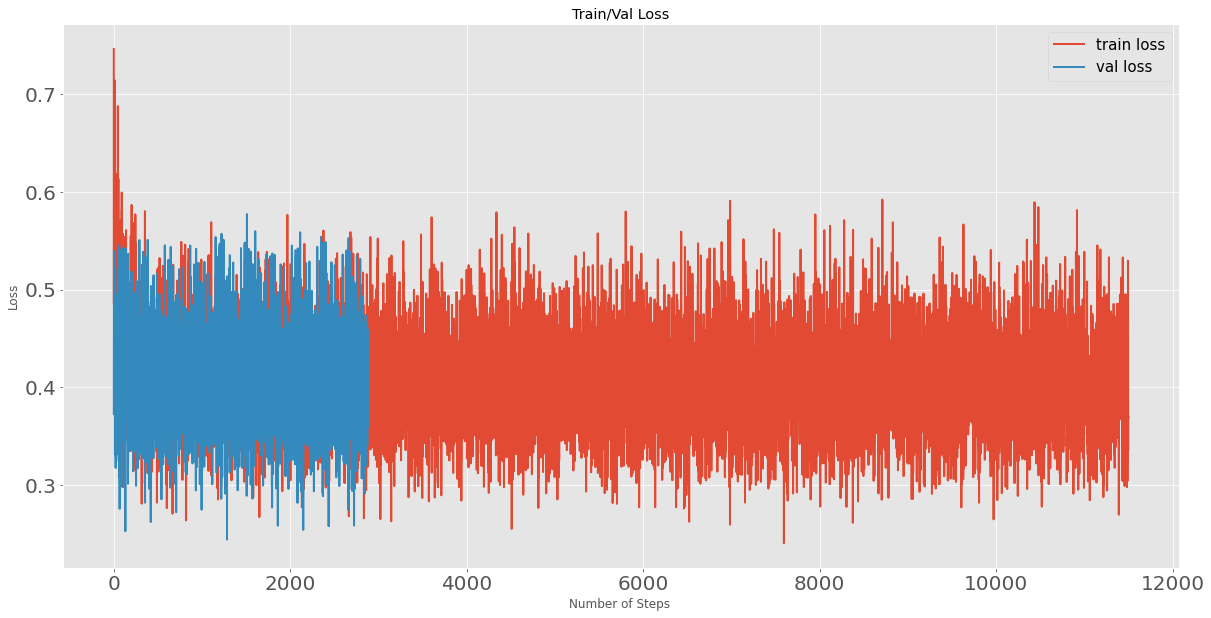

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the loss and acc
def plot_loss_fig(train_loss, val_loss):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_loss)), train_loss, label = 'train loss')
    plt.plot(range(len(val_loss)), val_loss, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Loss")  
    plt.ylabel('Loss') 
    plt.xlabel('Number of Steps ')
plot_loss_fig(train_all_loss, val_all_loss)

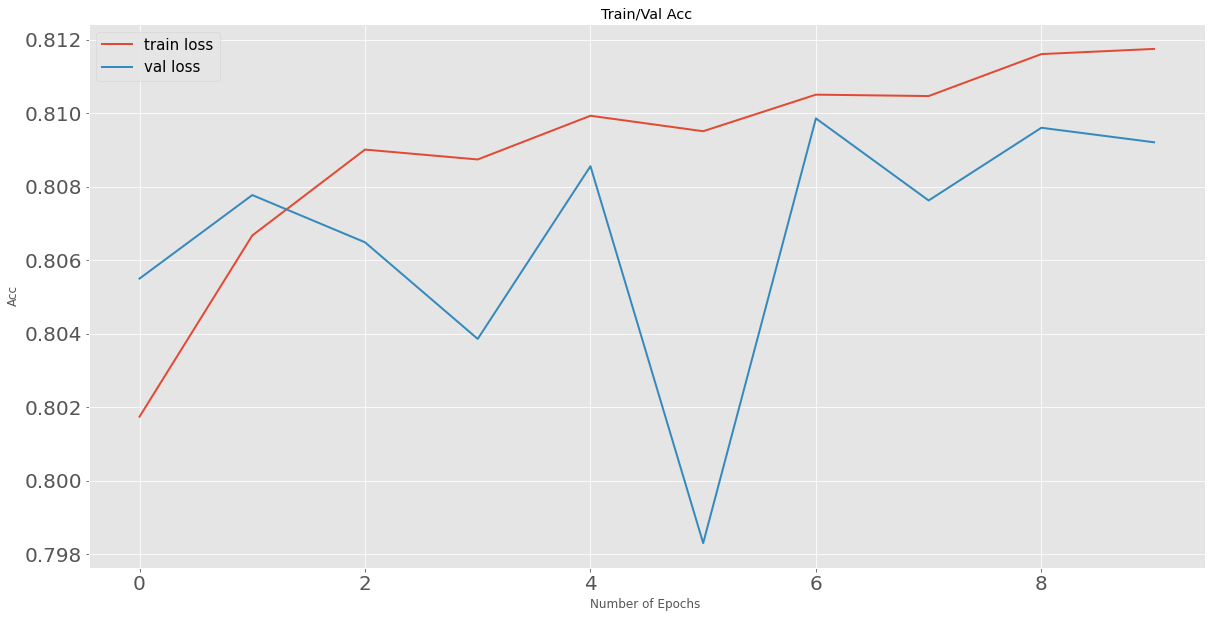

In [14]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pylab
import numpy as np
import os


# plot the acc and acc
def plot_acc_fig(train_acc, val_acc):
    myparams = {

   'axes.labelsize': '20',

   'xtick.labelsize': '20',

   'ytick.labelsize': '20',

   'lines.linewidth': 2,

   'legend.fontsize': '15',

   'font.family': 'Times New Roman',
}

    pylab.rcParams.update(myparams) 

    plt.style.use('ggplot')
    fig = plt.figure(figsize=(20,10))

    plt.plot(range(len(train_acc)), train_acc, label = 'train loss')
    plt.plot(range(len(val_acc)), val_acc, label = 'val loss')
    
    plt.grid(True)  # add grid
    plt.legend()
    plt.title("Train/Val Acc")  
    plt.ylabel('Acc') 
    plt.xlabel('Number of Epochs ')
plot_acc_fig(train_acc, val_acc)

In [15]:
torch.save(our_net.state_dict(), dir_path+'naturally_trained_model.pt')

# Adversarial Training Procedure


In [16]:
import copy 

LR = 0.01
NUM_EPOCH = 40
LOG_STEP = 200

adv_net = my_net()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(adv_net.parameters(), lr=LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCH)

train_all_loss = []
val_all_loss = []
train_acc = []
val_acc = []

attacker = torchattacks.PGD(adv_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
for epoch in range(NUM_EPOCH):
    adv_net.train()
    avg_top1 = []
    for batch_id, (train_sample, train_labels) in enumerate(train_loader): 
        train_labels = train_labels.long()
        # Generate adv. examples to mix in 
        atk_inds = np.random.choice(range(train_sample.shape[0]), size=train_sample.shape[0]//2, replace=False)
        orig_inds = [ind for ind in range(train_sample.shape[0]) if ind not in atk_inds]
        adv_samples = attacker(normalization(train_sample[atk_inds], mean=mean, std=std).float(), train_labels[atk_inds])
        orig_samples = train_sample[orig_inds]
        mixed_set = torch.cat((adv_samples, orig_samples))
        mixed_labels = torch.cat((train_labels[atk_inds], train_labels[orig_inds]))
        
        output = adv_net(normalization(mixed_set, mean=mean, std=std).float())
        loss = criterion(output, mixed_labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_all_loss.append(loss.item())
        top1 = topk(output, train_labels, ks=(1,))
        avg_top1.extend(top1)
        if batch_id % LOG_STEP ==0:
            print('Epoch {} Current Step {}/{}: loss is {losses:.6f}'
                  .format(str(epoch) ,str(batch_id), str(len(train_loader)), losses = loss.item()))
    train_acc.append(np.mean(avg_top1))
    adv_net.eval()
    avg_top1 = []
    with torch.no_grad():
        for  batch_id, (val_sample, val_labels) in enumerate(val_loader):
            val_labels = val_labels.long()
            outputs = adv_net(normalization(val_sample, mean=mean, std=std).float())
            loss = criterion(outputs, val_labels)
            val_all_loss.append(loss.item())
            top1 = topk(outputs, val_labels, ks=(1,))
            avg_top1.extend(top1)
        print('------------------------------------------------')
        print('Epoch {} Validation acc is {top1:.6f}'
                  .format(str(epoch), top1 = np.mean(avg_top1)))
    val_acc.append(np.mean(avg_top1))

Epoch 0 Current Step 0/1150: loss is 0.686393
Epoch 0 Current Step 200/1150: loss is 0.529323
Epoch 0 Current Step 400/1150: loss is 0.451397
Epoch 0 Current Step 600/1150: loss is 0.543432
Epoch 0 Current Step 800/1150: loss is 0.542321
Epoch 0 Current Step 1000/1150: loss is 0.461087
------------------------------------------------
Epoch 0 Validation acc is 0.801128
Epoch 1 Current Step 0/1150: loss is 0.561603
Epoch 1 Current Step 200/1150: loss is 0.473327
Epoch 1 Current Step 400/1150: loss is 0.488468
Epoch 1 Current Step 600/1150: loss is 0.446754
Epoch 1 Current Step 800/1150: loss is 0.514876
Epoch 1 Current Step 1000/1150: loss is 0.557276
------------------------------------------------
Epoch 1 Validation acc is 0.801553
Epoch 2 Current Step 0/1150: loss is 0.611508
Epoch 2 Current Step 200/1150: loss is 0.562928
Epoch 2 Current Step 400/1150: loss is 0.494411
Epoch 2 Current Step 600/1150: loss is 0.589553
Epoch 2 Current Step 800/1150: loss is 0.464500
Epoch 2 Current Step

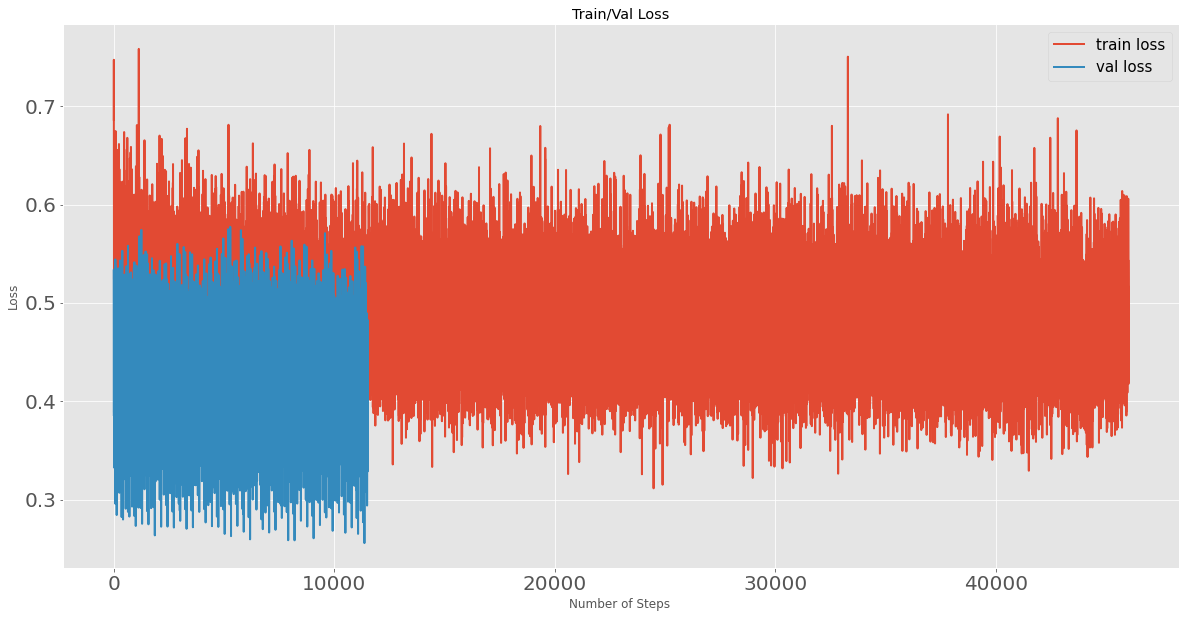

In [17]:
plot_loss_fig(train_all_loss, val_all_loss)

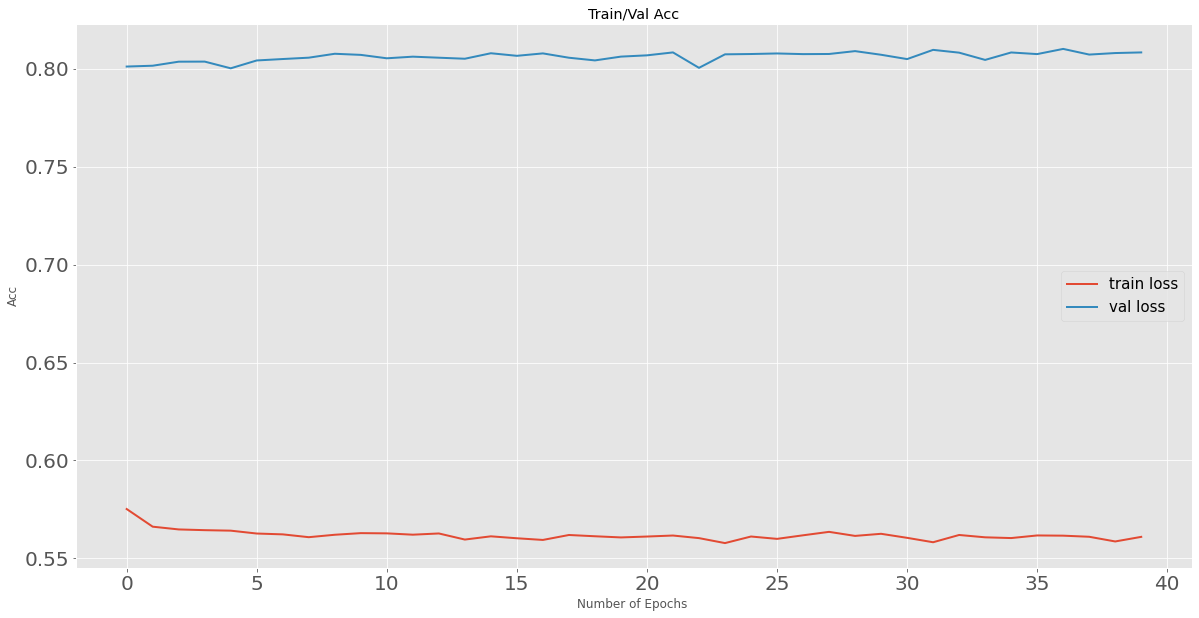

In [18]:
plot_acc_fig(train_acc, val_acc)

In [19]:
from torch import unsqueeze
num_wrong_nat = 0
num_attempt_nat = 0
num_wrong_adv = 0
num_attempt_adv = 0
for batch_id, (train_sample, train_labels) in enumerate(train_loader):
    if batch_id > 10:
        break
    for j in range(train_sample.shape[0]):
        instance = unsqueeze(train_sample[j], 0)
        label = unsqueeze(train_labels[j], 0)

        attacker_nat = torchattacks.PGD(our_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_nat(normalization(instance, mean=mean, std=std).float(), label.long())
        model_guess_nat = our_net(normalization(instance, mean=mean, std=std).float()).max(1).indices
        adv_guess_nat = our_net(normalization(adv_image, mean=mean, std=std).float()).max(1).indices
        if model_guess_nat !=  adv_guess_nat:
            num_wrong_nat += 1
        num_attempt_nat += 1

        attacker_adv = torchattacks.PGD(adv_net, eps=16/255, alpha=2/255, steps=20, random_start=True)
        adv_image = attacker_adv(normalization(instance, mean=mean, std=std).float(), label.long())
        model_guess_adv = adv_net(normalization(instance, mean=mean, std=std).float()).max(1).indices
        adv_guess_adv = adv_net(normalization(adv_image, mean=mean, std=std).float()).max(1).indices
        if model_guess_adv !=  adv_guess_adv:
            num_wrong_adv += 1
        num_attempt_adv += 1

print('Number Incorrect (natural model): {}'.format(num_wrong_nat))
print('Number Attempted (natural model): {}'.format(num_attempt_nat))

print('Number Incorrect (adversarially trained model): {}'.format(num_wrong_adv))
print('Number Attempted (adversarially trained model): {}'.format(num_attempt_adv))

Number Incorrect (natural model): 454
Number Attempted (natural model): 1408
Number Incorrect (adversarially trained model): 253
Number Attempted (adversarially trained model): 1408


In [20]:
torch.save(adv_net.state_dict(), dir_path+'adversarially_trained_model.pt')

# Recourse Generation


In [ ]:
! pip install carla-recourse

In [118]:
from carla.models.catalog import MLModelCatalog
from carla.data.catalog import OnlineCatalog
# load a catalog dataset
data_name = "adult"
dataset = OnlineCatalog(data_name)

In [122]:
dataset.df_train

0        0
1        1
2        0
3        1
4        0
        ..
36619    0
36620    0
36621    0
36622    1
36623    0
Name: income, Length: 36624, dtype: int64

In [10]:
nat_model_state = torch.load('naturally_trained_model.pt')
nat_model = my_net()
nat_model.load_state_dict(nat_model_state)

adv_model_state = torch.load('adversarially_trained_model.pt')
adv_model = my_net()
adv_model.load_state_dict(adv_model_state)


<All keys matched successfully>

In [11]:
import pandas as pd
data_source = ACSDataSource(survey_year='2014', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(ca_data)

In [12]:
mean = np.mean(features, axis=0)
std = np.std(features, axis=0)

def normalization(tensor, mean, std):
    return (tensor - mean) / std

def inverse_normalization(x, mean, std):
    return (x*std)+mean


In [13]:
features_cols = ['AGEP','COW','SCHL','MAR','OCCP','POBP','RELP','WKHP','SEX','RAC1P']

feature_cols = ['Age', 
            'Worker_Type', 
            'Education_Level', 
            'Marital_Status', 
            'Occupation_Code', 
            'State', 
            'Relationship', 
            'Hours_Per_Week', 
            'Sex', 
            'Race',
            #'Income_Greater_50k'
            ]

In [14]:
df = pd.DataFrame(normalization(features, mean, std), columns=feature_cols)
df['Income_Greater_50k'] = label
df['Income_Greater_50k'] = df['Income_Greater_50k'].astype(int)
df.head()

,Age,Worker_Type,Education_Level,Marital_Status,Occupation_Code,State,Relationship,Hours_Per_Week,Sex,Race,Income_Greater_50k
0,-0.454503,-0.607122,-0.560572,1.317399,2.157138,-0.610681,2.203857,-0.195370,-0.935280,-0.680778,0
1,0.303462,-0.607122,0.431979,0.222208,0.627915,-0.475040,-0.549273,1.717509,1.069198,-0.680778,0
2,-1.556996,-0.607122,0.183841,1.317399,0.291564,-0.738343,-0.090418,0.187206,-0.935280,-0.680778,0
3,-0.799032,-0.607122,0.183841,-0.872984,0.401073,-0.738343,-0.549273,0.569782,1.069198,-0.680778,1
4,-0.799032,1.531860,0.183841,-0.872984,0.569249,-0.738343,-0.319846,0.187206,-0.935280,-0.680778,0


In [15]:
SEED = 0
BATCH_SIZE = 128 



# generate the training data index and validation data index
np.random.seed(SEED)
random_index = np.random.rand(len(features))  
random_index = np.argsort(random_index)
train_index = random_index[: int(len(features)*0.8)]  # 80% data for training
val_index = random_index[int(len(features)*0.8):]


# generate the training data and validation data
train_data_df = df.iloc[train_index]
val_data_df = df.iloc[val_index]


In [16]:
from carla import Data

# Custom data set implementations need to inherit from the Data interface
class IncomeDataset(Data):

    def __init__(self, data, train, val, mean, std):
        # The data set can e.g. be loaded in the constructor
        self._dataset = data
        self._train = train
        self._val = val
        self._mean = mean
        self._std = std

    # List of all categorical features
    @property
    def categorical(self):
        return ['Worker_Type','Marital_Status', 'Occupation_Code', 'State', 'Relationship', 'Sex','Race']

    # List of all continuous features
    @property
    def continuous(self):
        return ['Age', 'Education_Level', 'Hours_Per_Week']

    # List of all immutable features which
    # should not be changed by the recourse method
    @property
    def immutables(self):
        return ['Sex','Race', 'State', 'Occupation_Code']

    # Feature name of the target column
    @property
    def target(self):
        return 'Income_Greater_50k'
    
    @property
    def df(self):
        return self._dataset
        pass

    @property
    def df_train(self):
        return self._train

    @property
    def df_test(self):
        return self._val

    def transform(self, df):
        print('hit')
        new_vals = normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)

    def inverse_transform(self, df):
        new_vals = inverse_normalization(df.values, self._mean, self._std)
        return pd.DataFrame(new_vals, columns=self._dataset.columns)
    
    def normalization(tensor, mean, std):
        return ((tensor - mean) / std).float()
    
    def inverse_normalization(x, mean, std):
        return (x*std)+mean
    
ds = IncomeDataset(df, train_data_df, val_data_df, mean, std)

/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow/python/f

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [17]:
from carla import MLModel

# Custom black-box models need to inherit from
# the MLModel interface
class MyOwnModel(MLModel):
    def __init__(self, data, model):
        super().__init__(data)
        # The constructor can be used to load or build an
        # arbitrary black-box-model
        self._mymodel = model

    # List of the feature order the ml model was trained on
    @property
    def feature_input_order(self):
        return ['Age', 'Worker_Type','Education_Level','Marital_Status','Occupation_Code','State','Relationship','Hours_Per_Week','Sex','Race']

    # The ML framework the model was trained on
    @property
    def backend(self):
        return "pytorch"

    # The black-box model object
    @property
    def raw_model(self):
        return self._mymodel

    # The predict function outputs
    # the continuous prediction of the model
    def predict(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        return self._mymodel(x).max(1).indices

    # The predict_proba method outputs
    # the prediction as class probabilities
    def predict_proba(self, x):
        if isinstance(x, np.ndarray):
            x = torch.Tensor(x)
        elif isinstance(x, pd.DataFrame):
            x = torch.Tensor(x.values)
        logits = self._mymodel(x)
        probs = torch.nn.functional.softmax(logits, dim=1)
        return probs.detach().numpy()
    
nat_model_carla = MyOwnModel(ds, nat_model)
adv_model_carla = MyOwnModel(ds, adv_model)

In [25]:
#from carla import OnlineCatalog, MLModelCatalog
from carla.recourse_methods import GrowingSpheres

# # get factuals from the data to generate counterfactual examples
factuals = ds.df.iloc[:1000]

# # load a recourse model and pass black box model
gs_1 = GrowingSpheres(nat_model_carla)

# # generate counterfactual examples
counterfactuals_1 = gs_1.get_counterfactuals(factuals)

# # load a recourse model and pass black box model
gs_2 = GrowingSpheres(adv_model_carla)

# # generate counterfactual examples
counterfactuals_2 = gs_2.get_counterfactuals(factuals)


In [26]:
transformed_factuals = inverse_normalization(factuals.drop(ds.target, axis=1), mean, std)

In [27]:
transformed_factuals.head(n=10).transpose()

,0,1,2,3,4,5,6,7,8,9
Age,36.0,47.0,20.0,31.0,31.0,33.0,44.0,41.0,58.0,35.0
Worker_Type,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,6.0,2.0
Education_Level,16.0,20.0,19.0,19.0,19.0,16.0,15.0,9.0,21.0,22.0
Marital_Status,5.0,3.0,5.0,1.0,1.0,4.0,1.0,4.0,1.0,5.0
Occupation_Code,9610.0,5700.0,4840.0,5120.0,5550.0,9620.0,9130.0,4110.0,4920.0,420.0
State,22.0,39.0,6.0,6.0,6.0,6.0,303.0,303.0,29.0,6.0
Relationship,12.0,0.0,2.0,0.0,1.0,0.0,1.0,10.0,0.0,0.0
Hours_Per_Week,35.0,60.0,40.0,45.0,40.0,40.0,40.0,40.0,80.0,40.0
Sex,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0
Race,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0


In [28]:
transformed_counterfactuals_1 = inverse_normalization(counterfactuals_1.drop(ds.target, axis=1), mean, std)

In [29]:
transformed_counterfactuals_2 = inverse_normalization(counterfactuals_2.drop(ds.target, axis=1), mean, std)

In [30]:
transformed_counterfactuals_1.head(n=10).transpose()

,0,1,2,3,4,5,6,7,8,9
Age,43.223984,NaN,33.980849,37.179843,36.335748,35.670484,43.036945,42.674394,NaN,NaN
Worker_Type,2.135348,NaN,2.135348,2.135348,2.135348,2.135348,2.135348,2.135348,NaN,NaN
Education_Level,21.190431,NaN,20.896654,21.439011,19.658846,23.762511,21.343389,21.287016,NaN,NaN
Marital_Status,2.594212,NaN,2.594212,2.594212,2.594212,4.420377,2.594212,4.420377,NaN,NaN
Occupation_Code,9610.000000,NaN,4840.000000,5120.000000,5550.000000,9620.000000,9130.000000,4110.000000,NaN,NaN
State,22.000000,NaN,6.000000,6.000000,6.000000,6.000000,303.000000,303.000000,NaN,NaN
Relationship,2.394105,NaN,2.394105,2.394105,2.394105,2.394105,2.394105,6.752780,NaN,NaN
Hours_Per_Week,48.742134,NaN,43.719818,46.549600,44.631837,52.680831,48.046049,51.188857,NaN,NaN
Sex,1.000000,NaN,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,NaN,NaN
Race,1.000000,NaN,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,NaN,NaN


In [31]:
transformed_counterfactuals_2.head(n=10).transpose()

,0,1,2,3,4,5,6,7,8,9
Age,41.976163,NaN,31.905148,36.534932,36.612304,48.088057,54.153394,39.380154,NaN,NaN
Worker_Type,2.135348,NaN,2.135348,2.135348,2.135348,2.135348,2.135348,2.135348,NaN,NaN
Education_Level,20.781622,NaN,22.543885,21.802005,20.438046,22.638093,21.712661,21.309385,NaN,NaN
Marital_Status,2.594212,NaN,4.420377,2.594212,2.594212,2.594212,2.594212,4.420377,NaN,NaN
Occupation_Code,9610.000000,NaN,4840.000000,5120.000000,5550.000000,9620.000000,9130.000000,4110.000000,NaN,NaN
State,22.000000,NaN,6.000000,6.000000,6.000000,6.000000,303.000000,303.000000,NaN,NaN
Relationship,2.394105,NaN,2.394105,2.394105,2.394105,2.394105,2.394105,2.394105,NaN,NaN
Hours_Per_Week,44.234827,NaN,44.360485,49.382288,45.555503,53.222255,51.006740,48.562601,NaN,NaN
Sex,1.000000,NaN,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000,NaN,NaN
Race,1.000000,NaN,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,NaN,NaN


In [32]:
sum(transformed_counterfactuals_1['Age'].isnull())

311

In [33]:
sum(transformed_counterfactuals_2['Age'].isnull())

304

In [61]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import List

from carla.models.api import MLModel
from carla.recourse_methods.api import RecourseMethod
from carla.evaluation.distances import get_distances


def yNN_manifold(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 5,
    dist_type: int = 1,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    positive_class = factuals.df.loc[factuals.df.index[factuals.df[factuals.target]==1]]
    
    nbrs = NearestNeighbors(n_neighbors=y).fit(positive_class.values)

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        knn = nbrs.kneighbors(row.values.reshape((1, -1)), y, return_distance=False)[0]
        distances_local = 0
        
        for idx in knn:
            neighbour = positive_class.iloc[idx]
            neighbour = neighbour.drop(mlmodel.data.target)
            neighbour = neighbour.values.reshape((1, -1))
            row_copy = row.drop(mlmodel.data.target)
            row_copy = row_copy.values.reshape((1, -1))
            
            distances_local += get_distances(row_copy, neighbour)[0][dist_type]
        distances.append((1 / y) * distances_local)
    return distances

def sphere_manifold(
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    sphere_factor: float = 0.2,
    dist_type: int = 1,
)-> List[List[float]]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    df_enc_norm_data = recourse_method.encode_normalize_order_factuals(
        mlmodel.data.raw, with_target=True
    )
    positive_class = df_enc_norm_data.loc[df_enc_norm_data.index[df_enc_norm_data[mlmodel.data.target]==1]]
    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
        all_deltas = np.asarray(df_enc_norm_data.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        all_dists = np.sum(np.square(np.abs(all_deltas)), axis=1, dtype=np.float)
        all_euc_dist = np.sqrt(all_dists)
        radius = np.mean(all_euc_dist)*sphere_factor

        pos_deltas = np.asarray(positive_class.drop(mlmodel.data.target, axis=1) - row.drop(mlmodel.data.target))
        pos_dists = np.sum(np.square(np.abs(pos_deltas)), axis=1, dtype=np.float)
        pos_euc_dist = np.sqrt(pos_dists)
        relevant_neighbors = np.where(pos_euc_dist < radius)[0]
        #print(relevant_neighbors)
        if len(relevant_neighbors) == 0:
            distances.append(np.nan)
        else:
            relevant_distances = pos_euc_dist[relevant_neighbors]
            distances.append(np.mean(relevant_distances))
        
    return distances

In [62]:
ynn_1 = yNN_manifold(ds, counterfactuals_1, gs_1, nat_model_carla)



In [63]:
ynn_2 = yNN_manifold(ds, counterfactuals_2, gs_2, adv_model_carla)



In [77]:
ynn_1 = [val for val in ynn_1 if not pd.isnull(val)]
ynn_2 = [val for val in ynn_2 if not pd.isnull(val)]

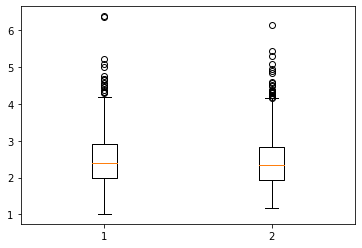

In [80]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([ynn_1, ynn_2])
plt.title('')
plt.show()

In [90]:
def dist(
    factuals: Data,
    counterfactuals: pd.DataFrame,
    recourse_method: RecourseMethod,
    mlmodel: MLModel,
    y: int = 5,
    dist_type: int = 2,
)-> List[float]:
    """
    TODO
    Parameters
    ----------
    counterfactuals: Generated counterfactual examples
    recourse_method: Method we want to benchmark
    y: Number of

    Returns
    -------
    List[List[float]]
    """
    distances = []
    N = counterfactuals.shape[0]

    for i, row in counterfactuals.iterrows():
        if pd.isna(row).any():
            distances.append(np.nan)
            continue
            
        original = factuals.df.drop(mlmodel.data.target, axis=1).iloc[i].values.reshape((1,-1))
        
        row_copy = row.drop(mlmodel.data.target)
        row_copy = row_copy.values.reshape((1, -1))
        distances.append(get_distances(row_copy, original)[0][dist_type])
    return distances

dist_1 = dist(ds, counterfactuals_1, gs_1, nat_model_carla)
dist_2 = dist(ds, counterfactuals_2, gs_2, adv_model_carla)



In [91]:
dist_1 = [val for val in dist_1 if not pd.isnull(val)]
dist_2 = [val for val in dist_2 if not pd.isnull(val)]


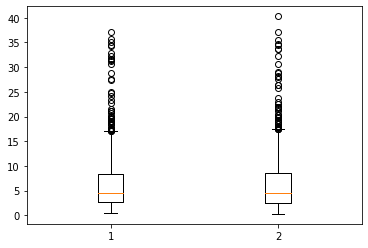

In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.boxplot([dist_1, dist_2])
plt.title('')
plt.show()

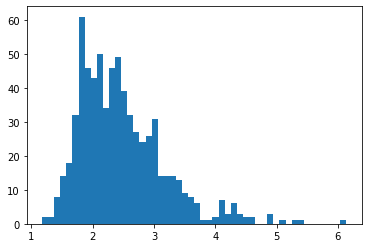

In [70]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(ynn_2, bins=50)
plt.show()

In [65]:
np.mean(ynn_1)

nan

In [47]:
factuals['Relationship']

0    12.0
1     0.0
2     2.0
3     0.0
4     1.0
5     0.0
6     1.0
7    10.0
8     0.0
9     0.0
Name: Relationship, dtype: float64

In [46]:
(factuals-counterfactuals).iloc[0, :]

Age                     -0.006584
Worker_Type              0.000000
Education_Level          0.000095
Marital_Status           4.000000
Occupation_Code       9609.000000
State                    0.000000
Relationship            11.000000
Hours_Per_Week           0.001795
Sex                      0.000000
Race                     0.000000
Income_Greater_50k      -1.000000
Name: 0, dtype: float64

In [ ]:
factuals = 
gs = GrowingSpheres(our_net)

# generate counterfactual examples
counterfactuals = gs.get_counterfactuals(factuals)